In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
from matplotlib import pyplot as plt
from plotting_functions import plot_test_perf_across_layers, plot_across_subjects, save_fMRI_simple, single_seed_mse_r2, find_rows_without_nan, pass_info_plot_hist2d
from untrained_results_funcs import compute_p_val, arrange_pvals_pd, remove_neg_r2, voxel_corrected_LLM_nested_full, mse_max_model, pool_across_seeds

According to this paper, https://arxiv.org/pdf/2406.15109, sentence length and sentence position perform much worse than untrained transformer architectures in brain score. My hunch is that this is because they use shuffled splits. Shuffled splits benefit the untrained transformer more because untrained LLM representations within a passsage are autocorrelated. They are autocorrelated because the model has access to previous sentences within the passage. The regression can then leverage this autocorrelation to enhance its brain score on shuffled splits. By contrast, when using sentence length + position, autocorrelation doesn't occur to the same extent. So I hypothesize that I can replicate their result when using shuffled splits. 

In [40]:
base = '/home3/ebrahim/what-is-brainscore/'

data_processed_folder = f'{base}data_processed/pereira/'

exp = ['243', '384']
br_labels_dict = {}
num_vox_dict = {}
ytest_dict = {}
mse_intercept_dict = {}
subjects_dict = {}
for e in exp:
    bre = np.load(f'{base}/pereira_data/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    mse_intercept_dict[e] = np.load(f'/home3/ebrahim/what-is-brainscore/results_all/results_pereira/mse_intercept_{e}_shuffled.npy')
    ytest_dict[e] = np.load(f'/home3/ebrahim/what-is-brainscore/results_all/results_pereira/y_test_ordered_{e}_shuffled.npy')
    subjects_dict[e] = np.load(f"{data_processed_folder}/subjects_{e}.npy", allow_pickle=True)
    
# load important things
figurePath = '/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/figures/pereira_untrained_obi/'
resultsFolder = f'{base}results_all/results_pereira/untrained/'
dataset = 'pereira'

In [41]:
lang_voxels_243 = np.argwhere(br_labels_dict['243']=='language').squeeze()
lang_voxels_384 = np.argwhere(br_labels_dict['384']=='language').squeeze()

In [42]:
# Let's load in the shuffled results 


In [43]:
# load non BIL models 
# Not using banded regression to better replicate the linked paper. I've found it doesn't make a big difference anyways when combining small feature spaces.
mse_PW_243, r2_PW_243, corr_PW_243 = single_seed_mse_r2(ytest_dict['243'], 'positional_WN', niters=1000, 
                            exp='243', layer_name='layer1', resultsFolder=resultsFolder, shuffled=True, compute_pearsonr=True)
mse_PW_384, r2_PW_384, corr_PW_384 = single_seed_mse_r2(ytest_dict['384'], 'positional_WN', niters=1000, 
                            exp='384', layer_name='layer1', resultsFolder=resultsFolder, shuffled=True, compute_pearsonr=True)

r2_PW_243_lang_perf = np.nanmean(np.clip(r2_PW_243[lang_voxels_243].squeeze(), 0, np.inf))
r2_PW_384_lang_perf = np.nanmean(np.clip(r2_PW_384[lang_voxels_384].squeeze(), 0, np.inf))
corr_PW_243_lang_perf = np.nanmean(np.clip(corr_PW_243[lang_voxels_243].squeeze(), 0, np.inf))
corr_PW_384_lang_perf = np.nanmean(np.clip(corr_PW_384[lang_voxels_384].squeeze(), 0, np.inf))

/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return (y_test - y_hat)**2, r2, corr


In [44]:
print(np.nanmean(r2_PW_384[lang_voxels_384]))

0.008273511559931002


In [47]:
perf_lang_243 = []
perf_lang_384 = []

perf_lang_243_corr = []
perf_lang_384_corr = []

for i in range(0,48):
    mse_bil_243, r2_gpt2_ut_243, corr_gpt2_ut_243 = single_seed_mse_r2(ytest_dict['243'], 'gpt2-xl-untrained-sp', niters=1, 
                                exp='243', layer_name=f'layer_{i}', resultsFolder=resultsFolder, shuffled=True, compute_pearsonr=True)  
    mse_bil_384, r2_gpt2_ut_384, corr_gpt2_ut_384 = single_seed_mse_r2(ytest_dict['384'], 'gpt2-xl-untrained-sp', niters=1, exp='384', 
                                layer_name=f'layer_{i}', resultsFolder=resultsFolder, shuffled=True, compute_pearsonr=True)
    r2_gpt2_ut_243_lang = np.nanmean(np.clip(r2_gpt2_ut_243[lang_voxels_243].squeeze(), 0, np.inf))
    r2_gpt2_ut_384_lang = np.nanmean(np.clip(r2_gpt2_ut_384[lang_voxels_384].squeeze(), 0, np.inf))
    corr_gpt2_ut_243_lang = np.nanmean(np.clip(corr_gpt2_ut_243[lang_voxels_243].squeeze(), 0, np.inf))
    corr_gpt2_ut_384_lang = np.nanmean(np.clip(corr_gpt2_ut_384[lang_voxels_384].squeeze(), 0, np.inf))
    
    perf_lang_243.append(r2_gpt2_ut_243_lang)
    perf_lang_384.append(r2_gpt2_ut_384_lang)

    perf_lang_384_corr.append(corr_gpt2_ut_384_lang)
    perf_lang_243_corr.append(corr_gpt2_ut_243_lang)

/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return (y_test - y_hat)**2, r2, corr


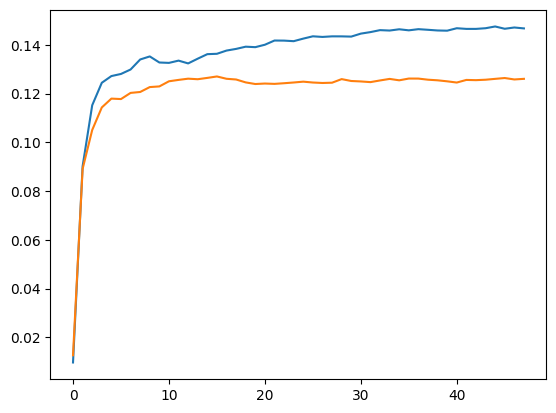

In [48]:
plt.plot(perf_lang_384)
plt.plot(perf_lang_243)

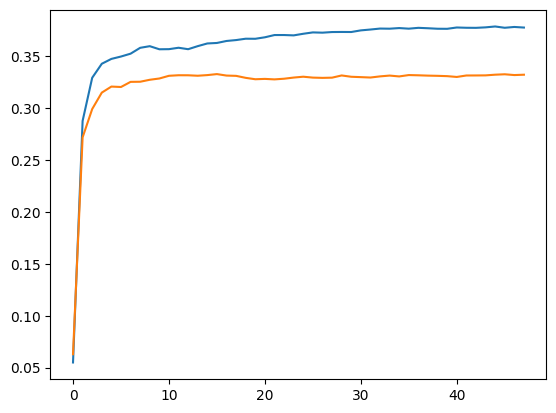

In [49]:
plt.plot(perf_lang_384_corr)
plt.plot(perf_lang_243_corr)

In [50]:
best_layer_lang_perf_243 = np.max(perf_lang_243)
best_layer_lang_perf_384 = np.max(perf_lang_384)


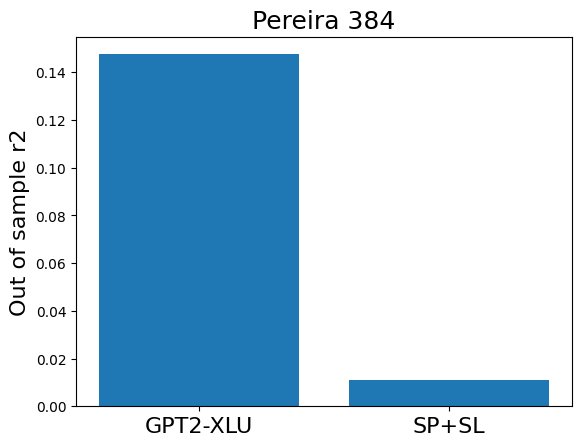

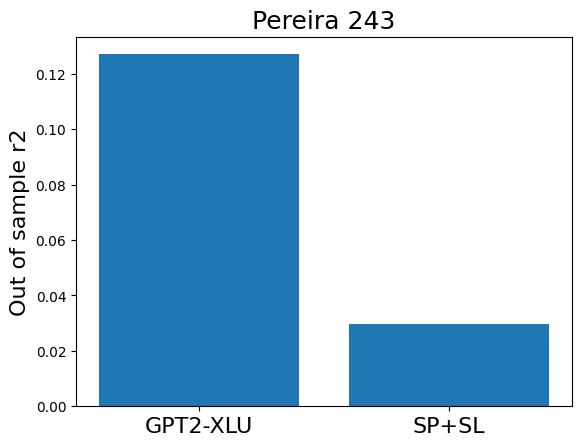

In [65]:
plt.ylabel("Out of sample r2", fontsize=16)
plt.title("Pereira 384", fontsize=18)
plt.bar(['GPT2-XLU', 'SP+SL'], [best_layer_lang_perf_384, r2_PW_384_lang_perf])
plt.xticks(fontsize=16)
plt.savefig("/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/figures/pereira_response/pereira_384_r2", dpi=300)
plt.show()
plt.ylabel("Out of sample r2", fontsize=16)
plt.title("Pereira 243", fontsize=18)
plt.xticks(fontsize=16)

plt.bar(['GPT2-XLU', 'SP+SL'], [best_layer_lang_perf_243, r2_PW_243_lang_perf])
plt.savefig("/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/figures/pereira_response/pereira_243_r2", dpi=300)

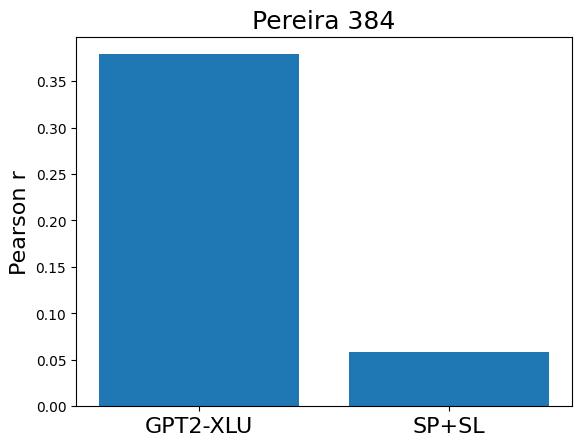

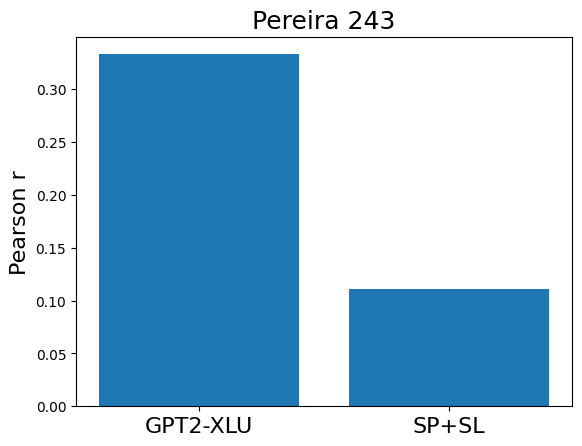

In [66]:
best_layer_lang_perf_243_corr = np.max(perf_lang_243_corr)
best_layer_lang_perf_384_corr = np.max(perf_lang_384_corr)

plt.ylabel("Pearson r", fontsize=16)
plt.title("Pereira 384", fontsize=18)
plt.bar(['GPT2-XLU', 'SP+SL'], [best_layer_lang_perf_384_corr, corr_PW_384_lang_perf])
plt.xticks(fontsize=16)
plt.savefig("/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/figures/pereira_response/pereira_384_pearsonr", dpi=300)
plt.show()
plt.ylabel("Pearson r", fontsize=16)
plt.title("Pereira 243", fontsize=18)
plt.xticks(fontsize=16)

plt.bar(['GPT2-XLU', 'SP+SL'], [best_layer_lang_perf_243_corr, corr_PW_243_lang_perf])
plt.savefig("/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/figures/pereira_response/pereira_243_pearsonr", dpi=300)